<a href="https://colab.research.google.com/github/KoMurase/movie_research_2/blob/master/movie_review_TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib
!apt-get -q -y install swig 
!apt-get install mecab
!apt-get install libmecab-dev
!apt-get install mecab-ipadic-utf8
!pip install mecab-python3
!pip install unidic-lite
#日本語フォントのインストール　（wordcloudなどで可視化するため）
!apt-get -y install fonts-ipafont-gothic

!pip install neologdn 
#半角を全角に変換
!pip install mojimoji

     |████████████████████████████████| 4.1MB 5.0MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-cp36-none-any.whl size=4120275 sha256=a9fdd5c80fe2300031a41d2f3d03ad0ff4f1c2148f91754d0043d62646013f61
  Stored in directory: /root/.cache/pip/wheels/b7/d9/a2/f907d50b32a2d2008ce5d691d30fb6569c2c93eefcfde55202
Successfully built japanize-matplotlib
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  swig3.0
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 11 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.1

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import lightgbm as lgb
import gc 
import numpy as np
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import train_test_split

#評価
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#混同行列
from sklearn.metrics import confusion_matrix 

import pandas as pd 
import matplotlib.pyplot as plt 
import japanize_matplotlib
%matplotlib inline  

import pandas as pd
import seaborn as sns
import warnings

In [3]:
import neologdn 
import string 
import mojimoji 
import re 

def text_preprocess(text):

  text = neologdn.normalize(text)
  #URLを除去する
  text = re.sub(
      r'(http|https)://([-\w]+\.)+[-\w]+(/[-\w./?%&=]*)?', 
      "",
      text)
  #全角から半角に
  text = mojimoji.zen_to_han(text) 

  #3D,2Dを残したい
  text = text.replace('3D','三次元')
  text = text.replace('2D','二次元')

  #数字をすべて0に置換 
  text = re.sub(r'\d+', '0', text)

  #string.punctuationの除去
  table = str.maketrans('', '', string.punctuation)
  text = text.translate(table) 

  text = text.replace("｡",'')
  text = text.replace("。",'')
  text = text.replace("，",'')
  text = text.replace(",",'')
  text = text.replace("、",'')
  text = text.replace("､",'')
  text = text.replace("…",'')
  text = text.replace("･",'')
  

  # 【】の除去
  text = re.sub(r'[【】]', '', text)
  # （）の除去
  text = re.sub(r'[（）()]', '', text)
  # ［］の除去
  text = re.sub(r'[［］\[\]]', '', text)
  #アルファベットをの大文字を小文字に変換
  text = text.lower()

  #改行コードの除去
  text = text.replace('\n', '')
  text = text.replace('\r\n','')
  
  #空白を除去
  #全角スペース
  text = text.replace('\u3000','')
  #タブキー
  text = text.replace('\t','')
  #半角
  #text = re.sub(r' ','', text) →英字幕などの指摘もあるため後で行う
  
  return text 

In [4]:
!pip install emoji 
!pip install nagisa 
#!pip install unicodedata 

import emoji
import nagisa

def delete_emoji(text):
  target_list = [w for w in text if w in emoji.UNICODE_EMOJI]
  for trg in target_list:
    text = text.replace(trg, "")
  return text 

     |████████████████████████████████| 51kB 2.3MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=8cf1941b5ce8e24179476be8482cffbf4787e19c8c7415d0ebdae0d16e2c5c1c
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji
     |████████████████████████████████| 21.5MB 7.2MB/s 
     |████████████████████████████████| 4.5MB 45.6MB/s 


In [5]:
import MeCab
def mecab_dokuritugo(text):
  tagger = MeCab.Tagger() 
  tagger.parse('')
  node = tagger.parseToNode(text) 
  word_list = [] 
  while node: 
    pos = node.feature.split(",")[0] ### 単語の品詞を抽出
    if pos in ["動詞","形容詞"]:
      ### 動詞,形容詞の原型を抽出 
      ### [6]は原型がカタカナになって返ってくる
      word = node.feature.split(",")[7]  
      word_list.append(word) 

    elif pos in ["名詞"]: ### 名詞はそのまま
      word = node.surface 
      word_list.append(word)
    node = node.next
  return " ".join(word_list)

#数値カラムに変換する
def prepro(df, col):
  df = df.copy() 
  df[col] = df[col].replace('-','-1') #回答してない人を-1で埋める
  df[col] = df[col].astype(float)

  return df

def pipeline(data):
  #data = pd.read_csv(path)
  data = data.sample(frac=0.4).reset_index(drop=True)
  #data = data[data["title"] == "レディ・プレイヤー1|Ready Player One"]
  #重複の削除
  data = data.drop_duplicates(keep='first') 

  #数値カラムに変換
  data = prepro(data, "score") 

  #0.5刻みにしたスコアの作成
  data["score2"] = data["score"]*2.0
  data["score2"] = data["score2"].round() / 2

  #空白行の削除
  data["length"] = data["review"].apply(lambda x: len(x))
  data = data[data["length"]>2]

  #preprocessing to text
  data["review"] = data["review"].apply(text_preprocess) 
  data["review"] = data["review"].apply(delete_emoji)
  #df["review"] = df["review"].apply(extra_preprocess)

  data["length"] = data["review"].apply(lambda x: len(x))
  #ノーコメントの削除
  data = data[data["length"]>1]

  #独立語のみの抽出
  data["review_tokenize"] = data["review"].apply(mecab_dokuritugo)
  data["length2"] = data["review_tokenize"].apply(lambda x: len(x))
  #前処理した結果空白になった行の削除
  data = data[data["length2"]>1]
  gc.collect()
  
  return data

In [6]:
path = "/content/drive/My Drive/movie_research/review_csv/"
data = pd.read_csv(path + 'SF_data.csv')
data2 = pd.read_csv(path + 'SF_data_2.csv')
data = pd.concat([data, data2], axis=0)
del data2 
gc.collect()

0

In [7]:
data[data['review'].isnull()]

,title,name,time,review,score,URL
83558,ターミネーター：新起動／ジェニシス|Terminator Genisys,H2の感想・評価,2020/08/25 20:40,NaN,3.4,https://filmarks.com//movies/58349?page=1


In [9]:
data = data.dropna()
data = data.sample(1000)
data = pipeline(data)
data = data[data.score != -1] 

In [10]:
data.shape

(374, 10)

In [11]:
import re
def is_japanese(text):
    return 1 if re.search(r'[ぁ-んァ-ン ァ-]', text) else 0

In [12]:
data['is_ja'] = data['review'].apply(is_japanese)

In [13]:
data1 = data[data['is_ja']==1]

In [ ]:
#data1 = data1.sample(20000)

In [14]:
#data1のみを使う 観測によると20000行以下でないと次の処理でクラッシュする
tfidf = TfidfVectorizer()
tfidf_df = tfidf.fit_transform(data1["review_tokenize"])
tfidf_df = pd.DataFrame(tfidf_df.toarray(), columns=tfidf.get_feature_names(), dtype="float16")

use_cols = []
thld_q90 = np.percentile(tfidf_df.std().values, 90)
for col in tfidf_df.columns:
    if thld_q90 < tfidf_df[col].std():
        use_cols.append(col)
          
tfidf_df = tfidf_df[use_cols]   
tfidf_cols = {col:col+'_tfidf' for col in tfidf_df.columns}
tfidf_df = tfidf_df.rename(columns=tfidf_cols) 

In [15]:
from sklearn.manifold import TSNE

clf = TSNE(n_components=2)
z = clf.fit_transform(tfidf_df)

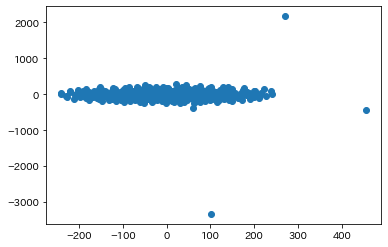

In [16]:
import matplotlib.pyplot as plt 
plt.scatter(*z.T)

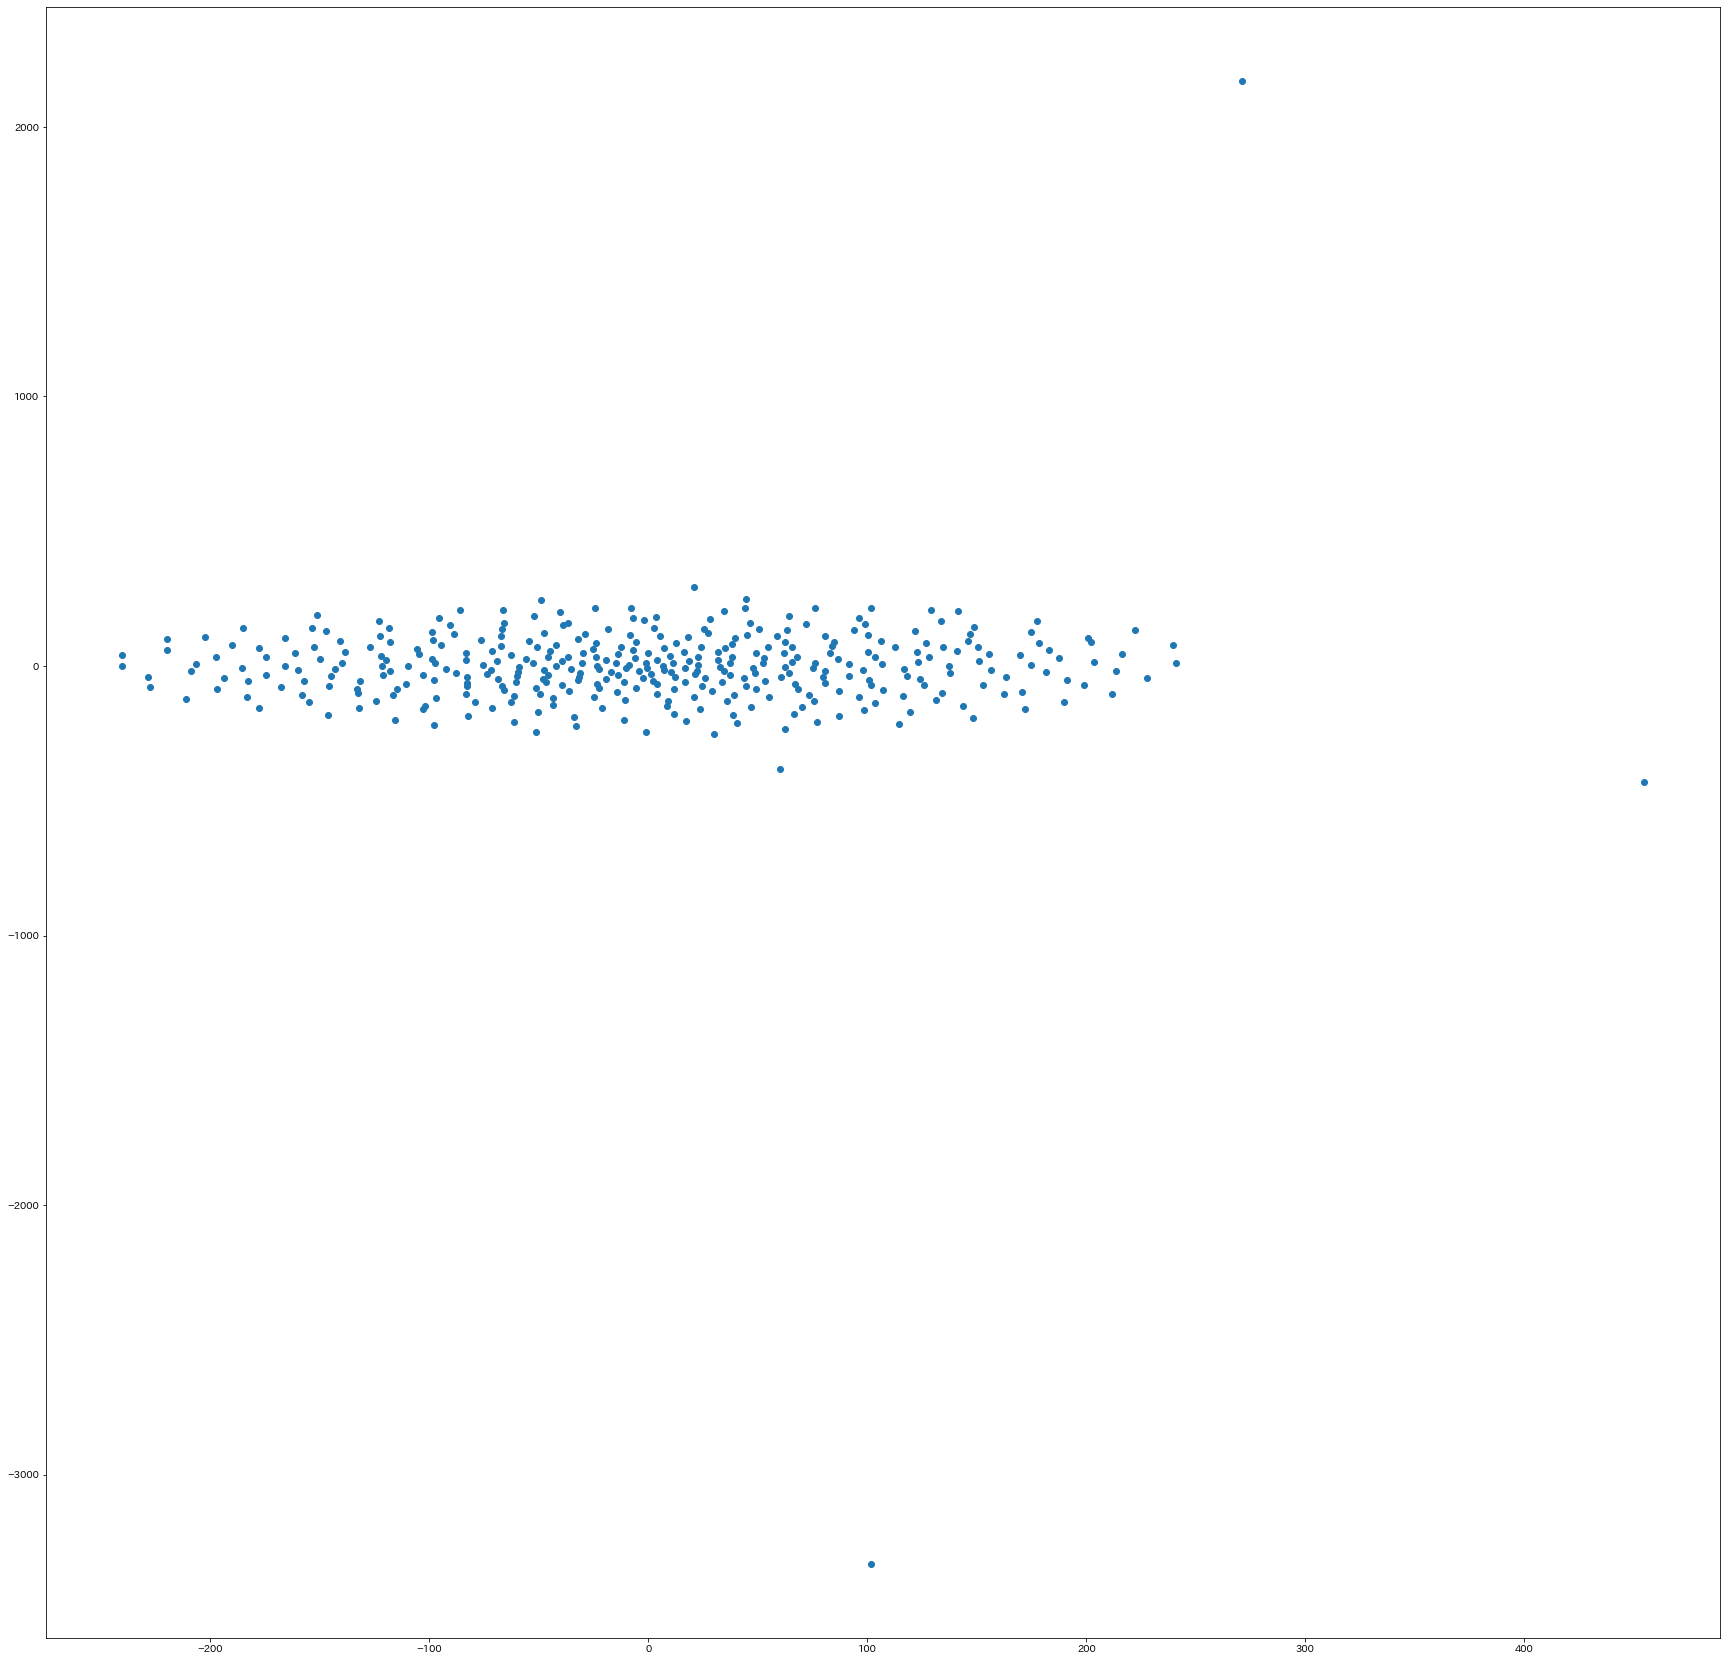

In [17]:
plt.figure(figsize=(30,30))
plt.scatter(*z.T)

In [18]:
z.shape

(374, 2)

In [19]:
data1.shape

(374, 11)

In [20]:
tSNE_df = pd.DataFrame(z, columns=['d0', 'd1'])
data1 = pd.concat([data1, tSNE_df], axis=1)

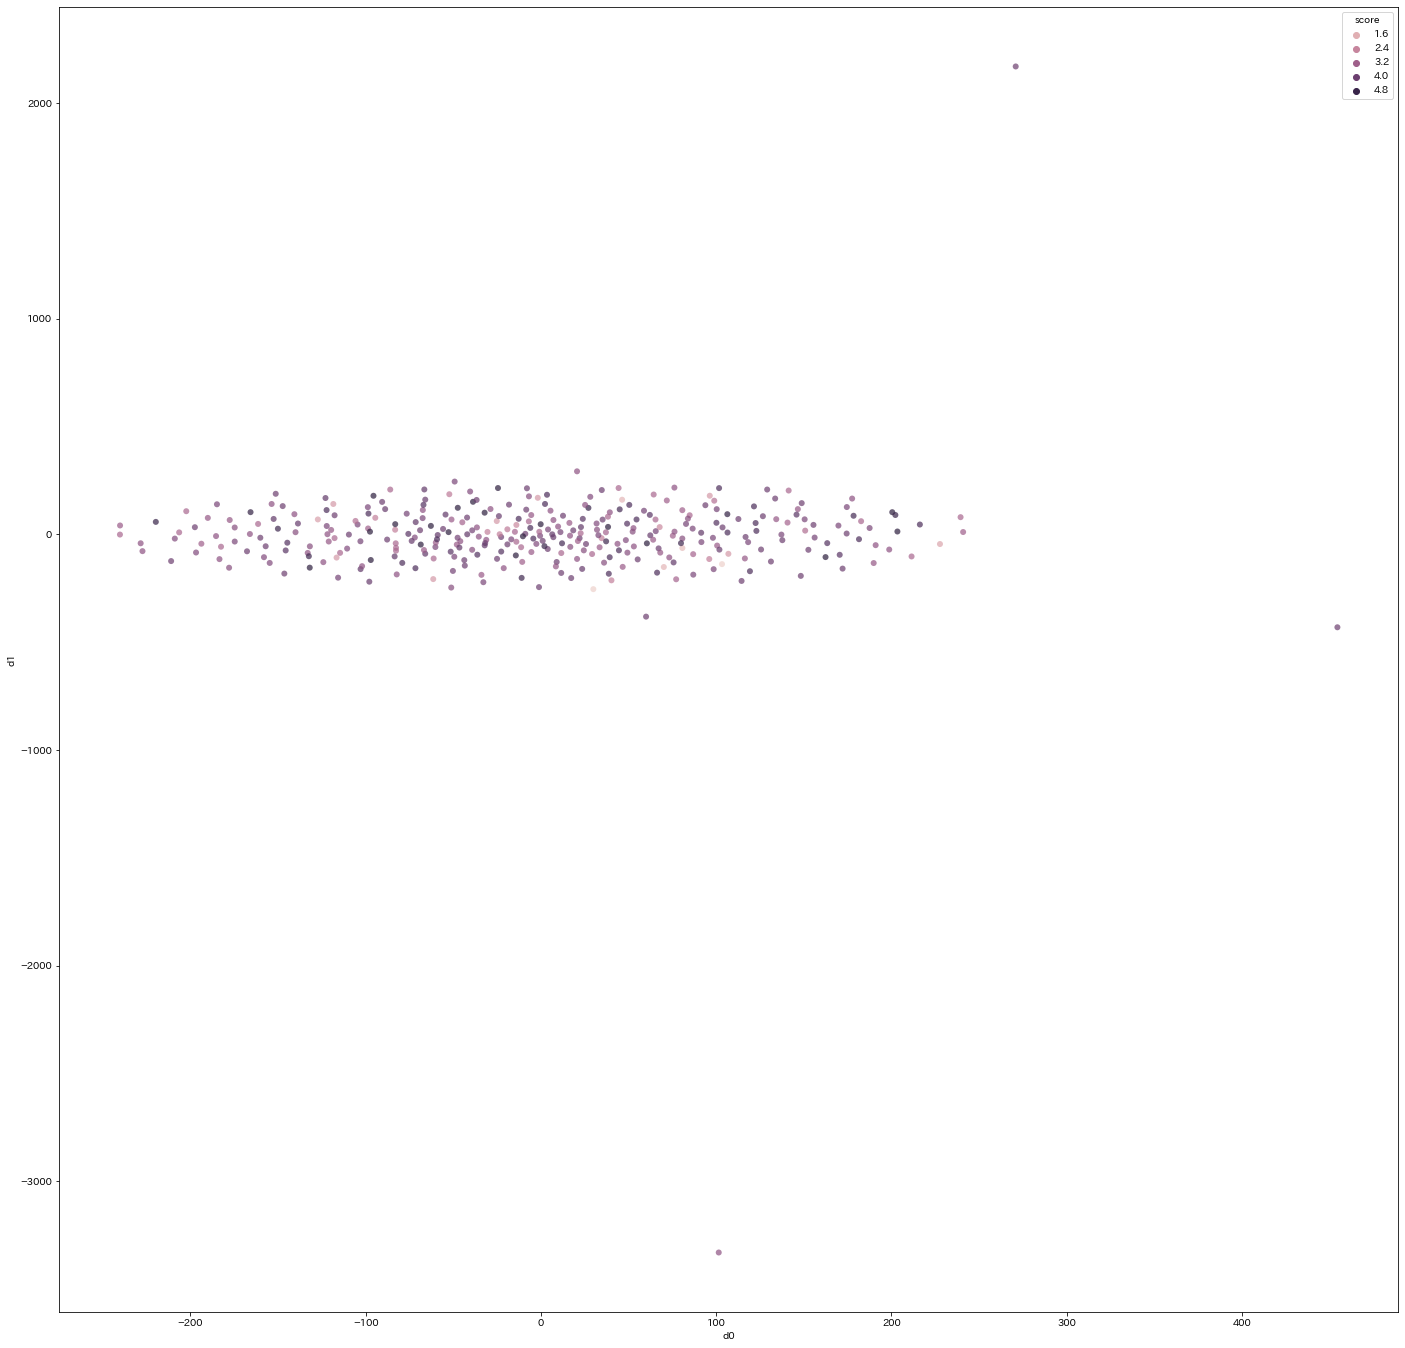

In [21]:
fig, ax = plt.subplots(figsize=(24, 24))
sns.scatterplot(data=data1, 
                x='d0', y='d1', 
                hue='score', ax=ax, edgecolors='none', linewidth=0, alpha=.7)